In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.descriptivestats import describe
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy as scipy
import arch

import fredapi as fa
from local_settings import fred as settings
fred = fa.Fred(settings['api_key'])

In [2]:
tickers = []

with open('tickers.txt') as f:
    for line in f:
        tickers.append(line.strip())

In [3]:
assets = {}

for ticker in tickers:
    assets[ticker] = fred.get_series(ticker).loc['2020-06-01':'2023-10-01']

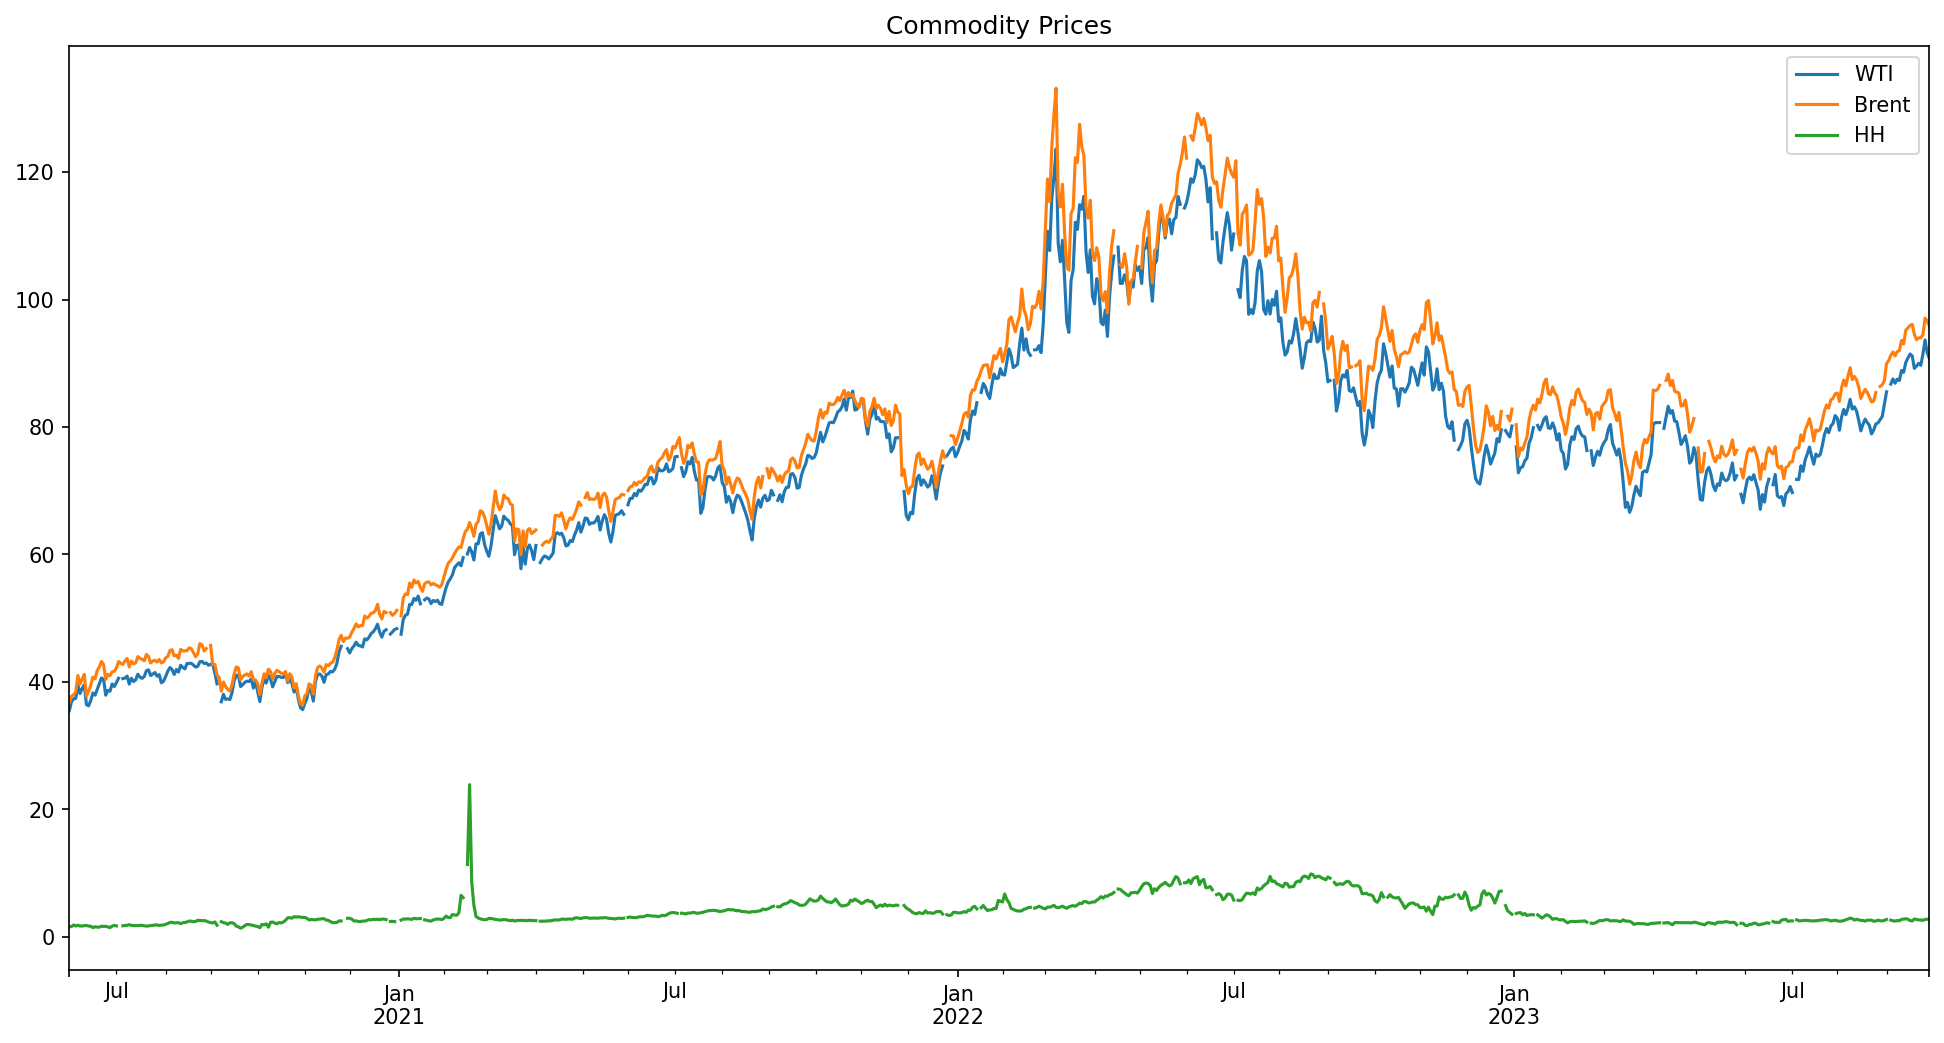

In [4]:
plt.figure(figsize=(16, 8), dpi=150) 

assets['DCOILWTICO'].plot(label='WTI')
assets['DCOILBRENTEU'].plot(label='Brent')
assets['DHHNGSP'].plot(label='HH')
#assets['PNGASEUUSDM'].plot(label='TTF')

plt.title('Commodity Prices')
plt.legend()

In [5]:
returns = pd.DataFrame.from_dict(assets).fillna(method='ffill')

for ticker in tickers:
    returns['Ret_' + ticker] = np.log(returns[ticker]) - np.log(returns[ticker].shift(1))

returns = returns.dropna() # only nulls left are the starting returns; will also have an issue with negative prices when series extended back far enough

returns.head()

,DCOILWTICO,DCOILBRENTEU,DHHNGSP,Ret_DCOILWTICO,Ret_DCOILBRENTEU,Ret_DHHNGSP
2020-06-02,36.88,37.72,1.58,0.038418,0.026324,-0.006309
2020-06-03,37.33,37.98,1.84,0.012128,0.006869,0.152341
2020-06-04,37.42,38.41,1.68,0.002408,0.011258,-0.090972
2020-06-05,39.49,41.00,1.80,0.053842,0.065254,0.068993
2020-06-08,38.17,39.66,1.68,-0.033998,-0.033229,-0.068993


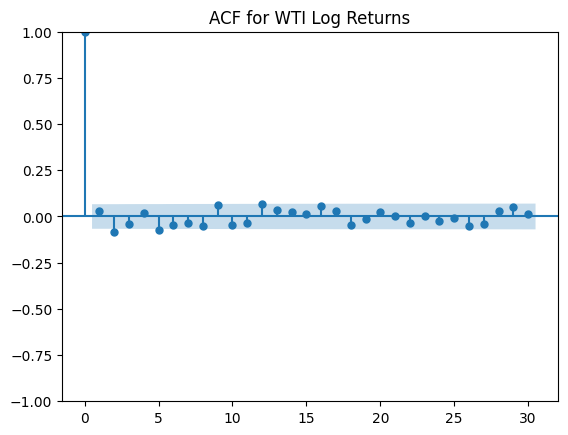

In [6]:
series_wti = returns['Ret_DCOILWTICO']

acf_ret_wti = acf(series_wti)
plot_acf(series_wti, lags=30, title='ACF for WTI Log Returns')
plt.show()

ACF of log returns indicates some AR/MA property among returns with lags 2, 5, 9, 12 being statistically significant

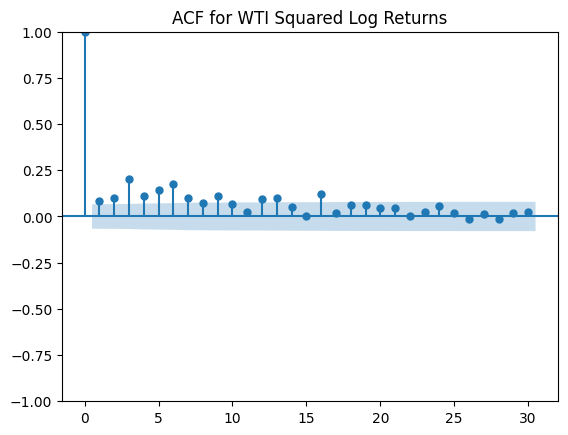

In [7]:
acf_retsq_wti = acf(series_wti**2)
plot_acf(series_wti**2, lags=30, title='ACF for WTI Squared Log Returns')
plt.show()

ACF of squared log returns indicates some AR property among squared returns for (G)ARCH with lags up to 9 and several others being statistically significant

In [8]:
describe(series_wti)

,Ret_DCOILWTICO
nobs,8.690000e+02
missing,0.000000e+00
mean,1.080642e-03
std_err,8.235387e-04
upper_ci,2.694748e-03
lower_ci,-5.334643e-04
std,2.427694e-02
iqr,2.791480e-02
iqr_normal,2.069327e-02
mad,1.793358e-02


negative skewness

high kurtosis

jarque_bera_pval close to zero --> H0 normality rejected

In [9]:
mu, sigma = np.mean(series_wti), np.std(series_wti)
x = np.random.normal(mu, sigma, 1000)
x = pd.Series(x, name='Normal Distribution')

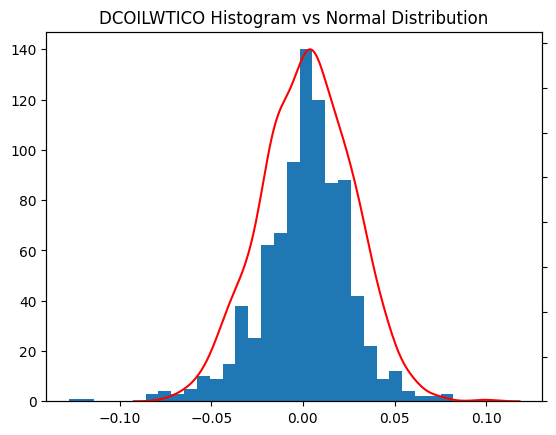

In [10]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.grid(False)
ax1.hist(series_wti, bins=30)
g1 = sns.kdeplot(x, ax=ax2, color='r')
g1.set(ylabel=None)
g1.set(yticklabels=[])
plt.title('DCOILWTICO Histogram vs Normal Distribution');

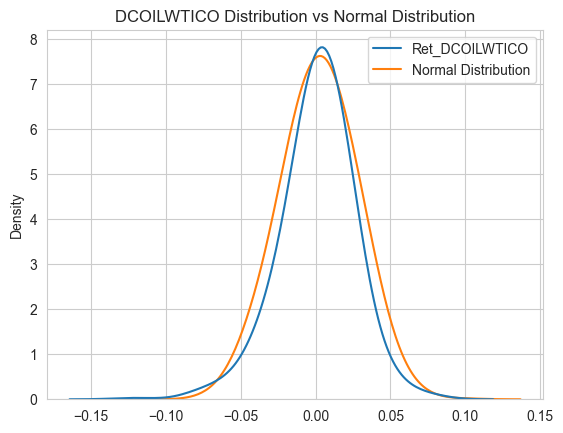

In [11]:
sns.set_style('whitegrid')
series_wti_norm = pd.concat([series_wti, x], axis=1)
sns.kdeplot(data=series_wti_norm, bw_method=0.5)
plt.title('DCOILWTICO Distribution vs Normal Distribution');

Leptokurtic distribution

Negative skew

Fat tails, particularly for negative returns

In [12]:
arch_test = het_arch(series_wti)
arch_test

(74.01086220849128,
 7.409383379921156e-12,
 7.995169376403505,
 2.158539007848078e-12)

In [13]:
arch_test = het_arch(series_wti, nlags=5)
arch_test

(58.30251863526131,
 2.7243829457468232e-11,
 12.417454974371093,
 1.1881259650242177e-11)

H0 no arch effects rejected (p-value close to zero)

In [128]:
proportion_in_train = 0.9
split = int(proportion_in_train*len(series_wti))

series_wti_train = series_wti.iloc[:split]
series_wti_test = series_wti.iloc[split+1:]

In [95]:
garch11 = arch.arch_model(series_wti_train, mean='Constant', vol='GARCH', p=1, q=1)
res_garch11 = garch11.fit()
res_garch11.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 42501858.72012455
Iteration:      2,   Func. Count:     17,   Neg. LLF: 4227906.878741824
Iteration:      3,   Func. Count:     28,   Neg. LLF: 60099033.43577653
Iteration:      4,   Func. Count:     39,   Neg. LLF: 67020144880.28921
Iteration:      5,   Func. Count:     48,   Neg. LLF: 76344.51173275821
Iteration:      6,   Func. Count:     59,   Neg. LLF: 2531.777714687399
Iteration:      7,   Func. Count:     69,   Neg. LLF: -1810.9613225437502
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1810.9613229324277
            Iterations: 11
            Function evaluations: 69
            Gradient evaluations: 7


C:\Users\afost\Documents\UW\Y2\S1\Thesis\cmd_forecast\Model\venv\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:         Ret_DCOILWTICO   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1810.96
Distribution:                  Normal   AIC:                          -3613.92
Method:            Maximum Likelihood   BIC:                          -3595.28
                                        No. Observations:                  782
Date:                Sun, Nov 19 2023   Df Residuals:                      781
Time:                        19:38:33   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.1322e-03  7.912e-04      1.431      0.152 [-4.185e-04,2.683e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.2272e-05  1.356e-05      4.591  4.410e-06 [3.569e-05,8.886e-05]
alpha[1]       0.1000  2.638e-02      3.790  1.505e-04   [4.829e-02,  0.152]
beta[1]        0.7999  2.700e-02     29.622 7.744e-193     [  0.747,  0.853]
============================================================================

Covariance estimator: robust
"""

In [96]:
garch11 = arch.arch_model(series_wti_train, mean='Zero', vol='GARCH', p=1, q=1)
res_garch11 = garch11.fit()
res_garch11.summary()

Iteration:      1,   Func. Count:      4,   Neg. LLF: -1809.999300967107
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1809.999301378689
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


C:\Users\afost\Documents\UW\Y2\S1\Thesis\cmd_forecast\Model\venv\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:         Ret_DCOILWTICO   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                1810.00
Distribution:                  Normal   AIC:                          -3614.00
Method:            Maximum Likelihood   BIC:                          -3600.01
                                        No. Observations:                  782
Date:                Sun, Nov 19 2023   Df Residuals:                      782
Time:                        19:38:34   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.2330e-05  1.267e-05      4.918  8.741e-07 [3.749e-05,8.717e-05]
alpha[1]       0.1000  2.641e-02      3.786  1.531e-04   [4.823e-02,  0.152]
beta[1]        0.8000  2.713e-02     29.485 4.478e-191     [  0.747,  0.853]
============================================================================

Covariance estimator: robust
"""

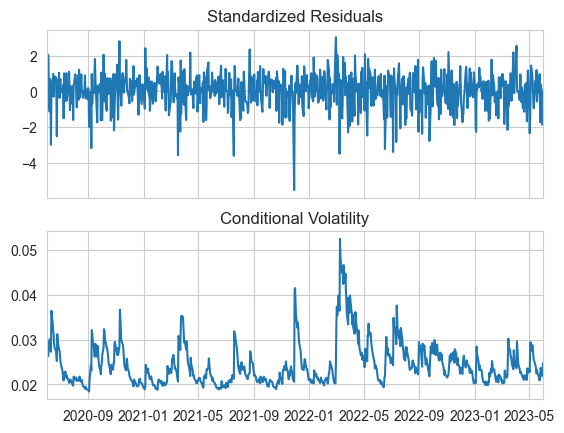

In [97]:
fig = res_garch11.plot()

In [98]:
acorr_ljungbox(res_garch11.std_resid**2, [10, 15, 20])

,lb_stat,lb_pvalue
10,5.827400,0.829550
15,10.114137,0.812500
20,12.494963,0.897987


In [99]:
res_garch11.aic

-3613.998602757378

In [100]:
res_garch11.bic

-3600.0130385357425

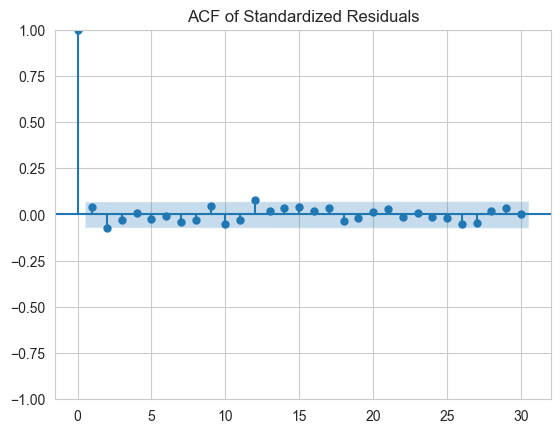

In [101]:
plot_acf(res_garch11.std_resid, lags=30, title='ACF of Standardized Residuals')
plt.show()

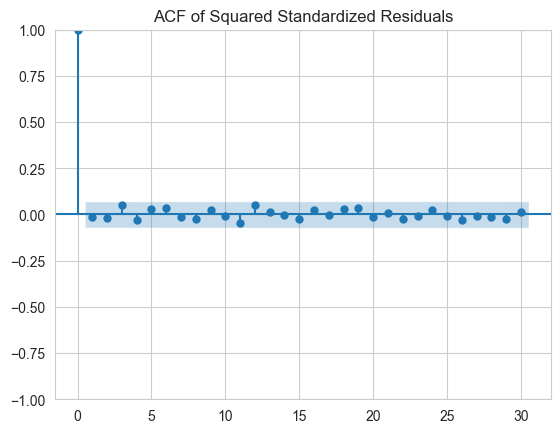

In [102]:
plot_acf(res_garch11.std_resid**2, lags=30, title='ACF of Squared Standardized Residuals')
plt.show()

All coefficients are statistically significant at 5% confidence level after removing the insignificant mean equation constant

Ljung-Box test on squared standardised residuals: H0 no autocorrelation not rejected at 5% at all 10, 15 & 20 lags

ACF of squared standardised residuals suggests the conditional variance equation is complete - although will see what GARCH(2,1) & GARCH(1,2) produce

ACF of standardised residuals suggets the mean equation can be modified - AR(2), AR(12) to be added

In [103]:
for_garch11 = res_garch11.forecast(horizon=len(series_wti_test))

<Axes: >

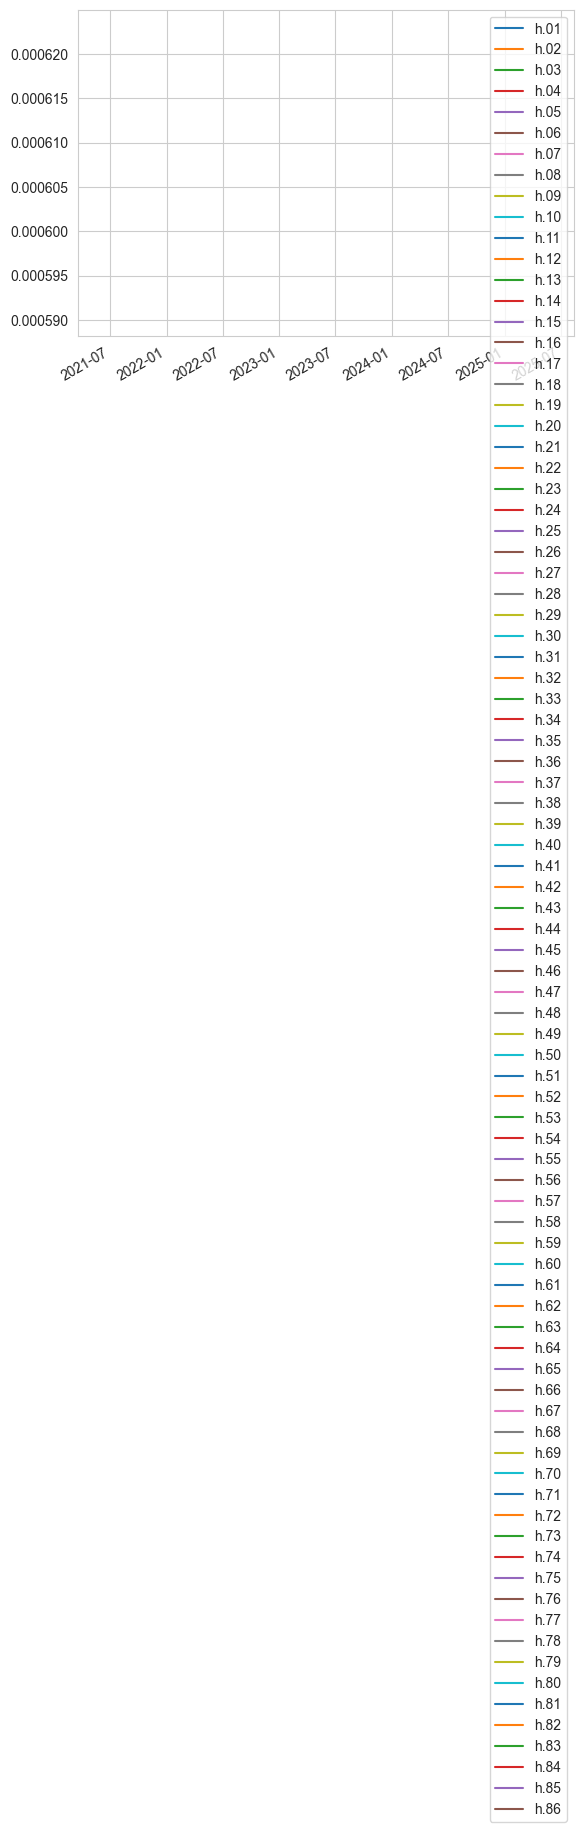

In [104]:
for_garch11.variance.plot()

In [105]:
for_garch11.mean

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.77,h.78,h.79,h.80,h.81,h.82,h.83,h.84,h.85,h.86
2023-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
for_garch11.variance**0.5

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.77,h.78,h.79,h.80,h.81,h.82,h.83,h.84,h.85,h.86
2023-05-31,0.024287,0.024356,0.024418,0.024473,0.024523,0.024567,0.024608,0.024644,0.024676,0.024705,...,0.024966,0.024966,0.024966,0.024966,0.024966,0.024966,0.024966,0.024966,0.024966,0.024966


<Axes: >

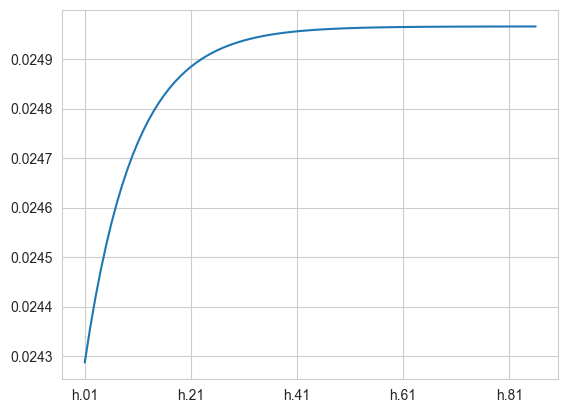

In [108]:
(for_garch11.variance**0.5).iloc[0].plot()

Prediction is run for the chosen number of days from the last available observation by default. The mean equation continues to be 0 as per the zero mean equation definition at the model setup stage. The variance equation evolves according to GARCH(1,1).

In [133]:
# MODIFY Vol_Test to calculate st dev for first 30 returns correctly instead of NA

In [129]:
series_wti_garch11_mean = pd.Series(for_garch11.mean.iloc[0].values, index=series_wti_test.index)
series_wti_train.rename('Ret_Train', inplace=True)
series_wti_test.rename('Ret_Test', inplace=True)
series_wti_garch11_mean.rename('Ret_Forecast', inplace=True)
series_wti_garch11 = pd.concat([series_wti_train, series_wti_test, series_wti_garch11_mean], axis=1)

series_wti_garch11['Vol_Train'] = series_wti_garch11[['Ret_Train']].rolling(30).std().shift(1) #30d std dev
series_wti_garch11['Vol_Test'] = series_wti_garch11[['Ret_Test']].rolling(30).std().shift(1) #30d std dev
series_wti_garch11_condvol = pd.Series((for_garch11.variance**0.5).iloc[0].values, index=series_wti_test.index) #conditional vol
series_wti_garch11_condvol.rename('Vol_Forecast', inplace=True)
series_wti_garch11 = pd.concat([series_wti_garch11, series_wti_garch11_condvol], axis=1)

series_wti_garch11

,Ret_Train,Ret_Test,Ret_Forecast,Vol_Train,Vol_Test,Vol_Forecast
2020-06-02,0.038418,NaN,NaN,NaN,NaN,NaN
2020-06-03,0.012128,NaN,NaN,NaN,NaN,NaN
2020-06-04,0.002408,NaN,NaN,NaN,NaN,NaN
2020-06-05,0.053842,NaN,NaN,NaN,NaN,NaN
2020-06-08,-0.033998,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-09-25,NaN,-0.003562,0.0,NaN,0.012104,0.024966
2023-09-26,NaN,0.019326,0.0,NaN,0.011994,0.024966
2023-09-27,NaN,0.024204,0.0,NaN,0.011721,0.024966
2023-09-28,NaN,-0.021801,0.0,NaN,0.011317,0.024966


<Axes: >

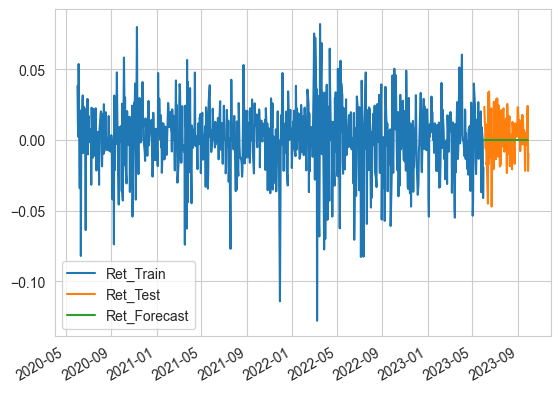

In [130]:
series_wti_garch11[['Ret_Train','Ret_Test','Ret_Forecast']].plot()

<Axes: >

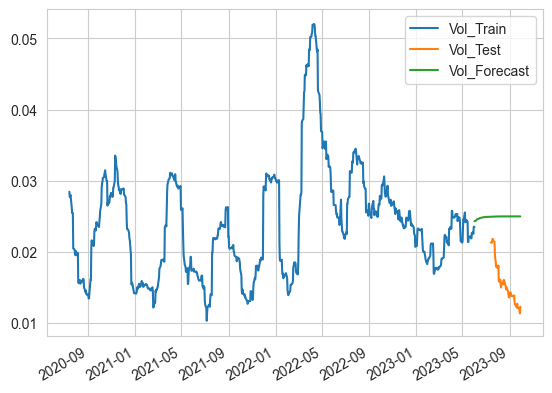

In [132]:
series_wti_garch11[['Vol_Train','Vol_Test','Vol_Forecast']].plot()